# Chapter 3. Creting Your Database

https://learning.oreilly.com/library/view/hands-on-apis-for/9781098164409/ch03.html

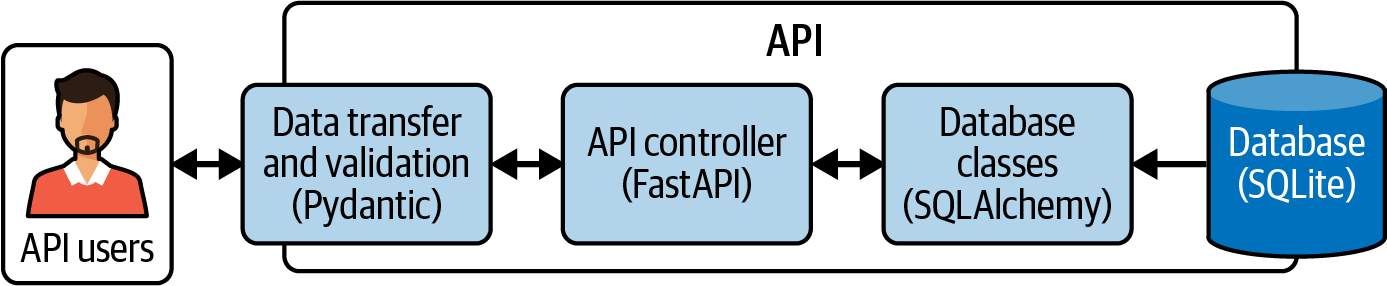

| Software name | Version | Purpose |
| :--- | :--- | :--- |
| **pytest** | 8 | Unit-testing library |
| **SQLAlchemy** | 2 | Object-Relational Mapping (ORM) library to connect Python to SQLite |
| **SQLite** | 3 | Stores the data used by the APIs |

```
.../portfolio-project (main) $ cd chapter3
.../chapter3 (main) $ sqlite3 fantasy_data.db
SQLite version 3.45.3 2024-04-15 13:34:05
Enter ".help" for usage hints.
sqlite>
```

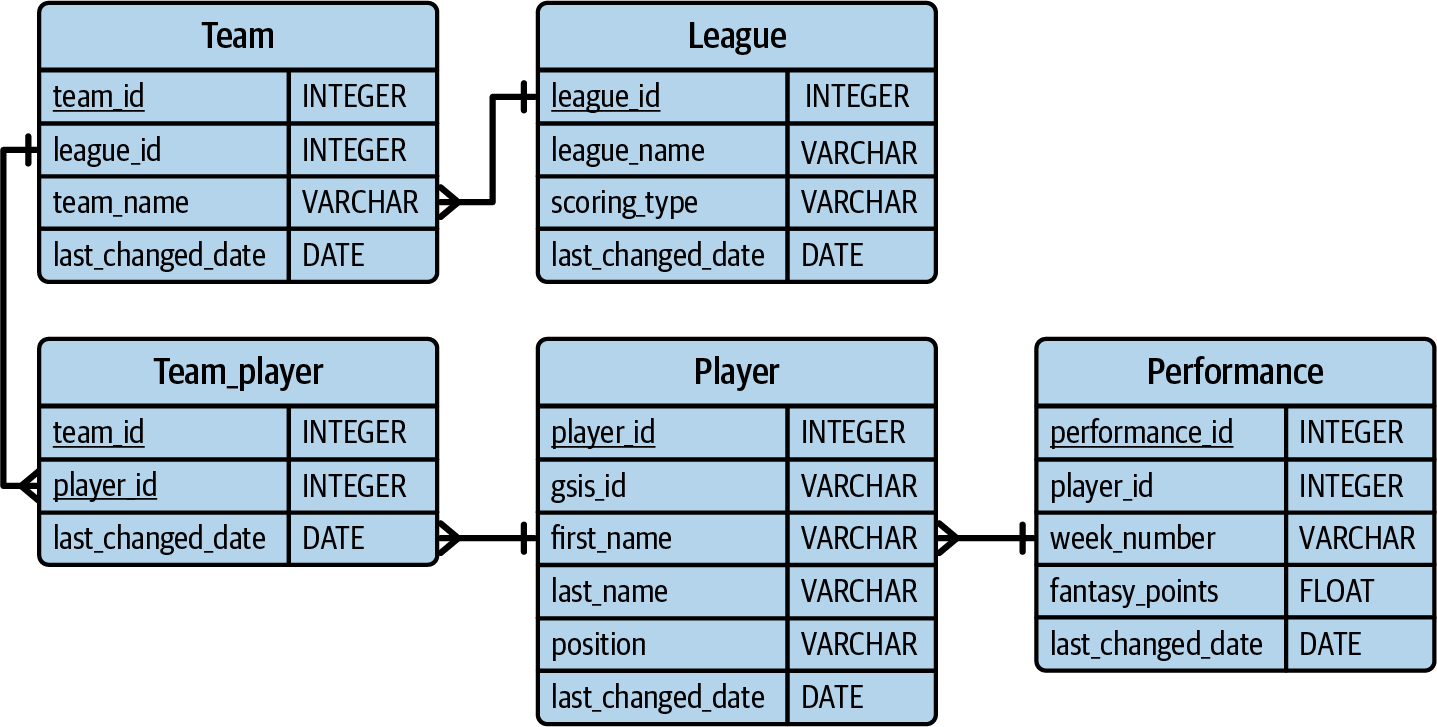

```
CREATE TABLE player (
        player_id INTEGER NOT NULL, 
        gsis_id VARCHAR, 
        first_name VARCHAR NOT NULL, 
        last_name VARCHAR NOT NULL, 
        position VARCHAR NOT NULL,
        last_changed_date DATE NOT NULL, 
        PRIMARY KEY (player_id)
);

CREATE TABLE performance (
        performance_id INTEGER NOT NULL, 
        week_number VARCHAR NOT NULL, 
        fantasy_points FLOAT NOT NULL, 
        player_id INTEGER NOT NULL, 
        last_changed_date DATE NOT NULL,
        PRIMARY KEY (performance_id), 
        FOREIGN KEY(player_id) REFERENCES player (player_id)
);

CREATE TABLE league (
        league_id INTEGER NOT NULL, 
        league_name VARCHAR NOT NULL, 
        scoring_type VARCHAR NOT NULL,
        last_changed_date DATE NOT NULL,  
        PRIMARY KEY (league_id)
);

CREATE TABLE team (
        team_id INTEGER NOT NULL, 
        team_name VARCHAR NOT NULL, 
        league_id INTEGER NOT NULL, 
        last_changed_date DATE NOT NULL, 
        PRIMARY KEY (team_id), 
        FOREIGN KEY(league_id) REFERENCES league (league_id)
);

CREATE TABLE team_player (
        team_id INTEGER NOT NULL, 
        player_id INTEGER NOT NULL, 
        last_changed_date DATE NOT NULL, 
        PRIMARY KEY (team_id, player_id), 
        FOREIGN KEY(team_id) REFERENCES team (team_id), 
        FOREIGN KEY(player_id) REFERENCES player (player_id)
);
```

```
sqlite> .tables
league       performance  player       team         team_player
sqlite>
```

INCLUDING AN EXTERNAL IDENTIFIER IN YOUR API
When data scientists use your API, they would like to combine your data with other sources for richer analytics products and models. To accomplish this, you need to provide them a standard external identifier that will be present in other data sources. For NFL player data, each data provider and fantasy website uses a different identifier. The most comprehensive identifier is generated by the NFL’s Game Statistics and Information System (GSIS). You will include the GSIS ID in your API to meet the needs of data scientists. Not every player has a GSID ID assigned, so it will allow nulls.



In “Designing APIs for Data Scientists”, I recommended that APIs support querying by the last changed date. This allows them to use APIs in data pipelines and only retrieve records that have changed since a point in time. (This is a major time-saver.) You will enable this by populating the last_changed_date column in each table.



In [2]:
import pandas as pd

dfplayer = pd.read_csv("./data/player_data.csv")
dfplayer.head()

,player_id,gsis_id,first_name,last_name,position,last_changed_date
0,1001,00-0023459,Aaron,Rodgers,QB,2024-04-18
1,1002,00-0023853,Matt,Prater,K,2024-04-18
2,1003,00-0024243,Marcedes,Lewis,TE,2024-04-18
3,1004,00-0025565,Nick,Folk,K,2024-04-18
4,1005,00-0025580,Mason,Crosby,K,2024-04-18


In [3]:
dfperformance = pd.read_csv("./data/performance_data.csv")
dfperformance.head()

,performance_id,week_number,fantasy_points,player_id,last_changed_date
0,2501,202301,20,1001,2024-03-01
1,2502,202301,22,1002,2024-03-01
2,2503,202301,13,1003,2024-03-01
3,2504,202301,15,1004,2024-03-01
4,2505,202301,3,1005,2024-03-01


In [4]:
dfleague = pd.read_csv("./data/league_data.csv")
dfleague.head()

,league_id,league_name,scoring_type,last_changed_date
0,5001,Pigskin Prodigal Fantasy League,PPR,2024-04-25
1,5002,Recurring Champions League,Half-PPR,2024-04-25
2,5003,AHAHFZZFFFL,Standard,2024-04-25
3,5004,Gridiron Gurus Fantasy League,PPR,2024-04-25
4,5005,Best League Ever,PPR,2024-04-25


In [5]:
dfteam = pd.read_csv("./data/team_data.csv")
dfteam.head()

,team_id,team_name,league_id,last_changed_date
0,1001,Roaring Kitties,5001,2024-04-23
1,1002,Pigskin Party,5001,2024-04-23
2,1003,Dallas Steers,5001,2024-04-23
3,1004,Never Gonna Give Up,5001,2024-04-23
4,1005,Fighting Catfish,5001,2024-04-23


In [6]:
dfteam_player = pd.read_csv("./data/team_player_data.csv")
dfteam_player.head()

,team_id,player_id,last_changed_date
0,1001,1001,2024-04-17
1,1002,1006,2024-04-17
2,1003,1008,2024-04-17
3,1004,1009,2024-04-17
4,1005,1010,2024-04-17


In [7]:
dfplayer.shape

(1018, 6)

In [8]:
dfperformance.shape

(17306, 5)

In [9]:
dfperformance.columns

Index(['performance_id', 'week_number', 'fantasy_points', 'player_id',
       'last_changed_date'],
      dtype='object')

In [10]:
dfperformance.dtypes

performance_id        int64
week_number           int64
fantasy_points        int64
player_id             int64
last_changed_date    object
dtype: object

In [11]:
dfperformance['last_changed_date'] = pd.to_datetime(dfperformance['last_changed_date'])

In [12]:
dfperformance[dfperformance['last_changed_date'] > '2024-04-01'].shape

(2711, 5)

In [13]:
dfleague.shape

(5, 4)

In [14]:
dfteam.shape

(20, 4)

In [15]:
dfteam_player.shape

(140, 3)

There are several ways to access this data in Python. For example, you could create a connection to the database and execute SQL queries directly. This sounds simple, but you would quickly run into several issues, such as mapping the SQLite data types into Python objects. You would also need to take steps to avoid SQL injection attacks when you accept input from your API users.

To avoid this manual work, you will use an ORM, which handles the process of reading database tables and creating Python objects from them. You will be using a very common Python ORM: SQLAlchemy.

| Filename | Purpose |
| :--- | :--- |
| `crud.py` | Helper function to query the database |
| `database.py` | Configures SQLAlchemy to use the SQLite database |
| `models.py` | Defines the SQLAlchemy classes related to the database tables |
| `requirements.txt` | Used to install specific versions of libraries with the pip package manager |
| `test_crud.py` | The pytest file to unit-test your SQLAlchemy files |

The term model is used in a lot of different ways in this book, which is unavoidable but confusing. In this instance, the SQLAlchemy model is a Python representation of the data from the SQLite database.



In [16]:
dfplayer.head()

,player_id,gsis_id,first_name,last_name,position,last_changed_date
0,1001,00-0023459,Aaron,Rodgers,QB,2024-04-18
1,1002,00-0023853,Matt,Prater,K,2024-04-18
2,1003,00-0024243,Marcedes,Lewis,TE,2024-04-18
3,1004,00-0025565,Nick,Folk,K,2024-04-18
4,1005,00-0025580,Mason,Crosby,K,2024-04-18


In [17]:
dfperformance.head()

,performance_id,week_number,fantasy_points,player_id,last_changed_date
0,2501,202301,20,1001,2024-03-01
1,2502,202301,22,1002,2024-03-01
2,2503,202301,13,1003,2024-03-01
3,2504,202301,15,1004,2024-03-01
4,2505,202301,3,1005,2024-03-01


In [20]:
dfteam_player.head()

,team_id,player_id,last_changed_date
0,1001,1001,2024-04-17
1,1002,1006,2024-04-17
2,1003,1008,2024-04-17
3,1004,1009,2024-04-17
4,1005,1010,2024-04-17


In [21]:
dfleague.head()

,league_id,league_name,scoring_type,last_changed_date
0,5001,Pigskin Prodigal Fantasy League,PPR,2024-04-25
1,5002,Recurring Champions League,Half-PPR,2024-04-25
2,5003,AHAHFZZFFFL,Standard,2024-04-25
3,5004,Gridiron Gurus Fantasy League,PPR,2024-04-25
4,5005,Best League Ever,PPR,2024-04-25


In [23]:
dfteam.head()

,team_id,team_name,league_id,last_changed_date
0,1001,Roaring Kitties,5001,2024-04-23
1,1002,Pigskin Party,5001,2024-04-23
2,1003,Dallas Steers,5001,2024-04-23
3,1004,Never Gonna Give Up,5001,2024-04-23
4,1005,Fighting Catfish,5001,2024-04-23


(api-book-part-one) davidd@DellXPSDavidD:~/2025/api-book-part-one/chapter3$ sqlite3 fantasy_data.db
SQLite version 3.37.2 2022-01-06 13:25:41
Enter ".help" for usage hints.
sqlite>

You are right at the prompt. Since you are inside the SQLite command-line interface (indicated by the `sqlite>` prompt), you need to use "dot commands" to see system information.

Here are the commands you need:

### 1\. The Direct Answer: `.schema`

To see the full SQL `CREATE` statements used to build the database, type:

```sql
sqlite> .schema
```

This will dump the schema for every table and index in the database.

### 2\. If the output is too overwhelming

If you have many tables and just want to see the list of table names first, use:

```sql
sqlite> .tables
```

Once you know the specific table name (e.g., `players`), you can view the schema for **just that table**:

```sql
sqlite> .schema players
```

[Image of SQL database schema structure]

### 3\. The "Data Scientist" View (Tabular)

As a data scientist, you might prefer seeing the schema in a tabular format (similar to `df.info()` in pandas) rather than reading raw SQL `CREATE` statements.

To do this, use the `PRAGMA` command. Note that this is a SQL command, so **it requires a semicolon** at the end:

```sql
sqlite> .headers on
sqlite> .mode column
sqlite> PRAGMA table_info(your_table_name);
```

*(Replace `your_table_name` with an actual table from your database).*

### Summary of Commands

| Command | Description |
| :--- | :--- |
| `.schema` | Shows the `CREATE TABLE` statements for the whole DB. |
| `.tables` | Lists only the table names. |
| `.quit` | Exits the `sqlite3` interface. |

-----

**Would you like me to show you how to generate an Entity Relationship Diagram (ERD) from this database using Python and `sqlalchemy` instead?**

This is a very common workflow. In the real world, we rarely write SQLAlchemy models from scratch if a database already exists; we "reflect" or "introspect" the database to generate the code.

Here is the two-step process to achieve exactly what you want: visualizing the schema (ERD) and auto-generating the `models.py` file.

### Step 1: Visualizing the Schema (The ERD)

To generate a visual representation (a PNG or PDF) of your SQLite database, the best Python tool is `eralchemy2` (a maintained fork of the original `eralchemy`).

**1. Install the requirements**
You will likely need the system-level GraphViz library installed first, then the Python library.

```bash
# Since you appear to be on Ubuntu/WSL:
sudo apt-get install graphviz

# Then install the python library
pip install eralchemy2 SQLAlchemy
```

**2. Run the command**
Run this command from your terminal (outside the sqlite3 prompt). Note the three slashes `///` for a relative path to the file.

```bash
eralchemy2 -i sqlite:///fantasy_data.db -o schema.png
```

This will create a `schema.png` file in your current directory that visualizes tables, columns, and relationships.

-----

### Step 2: Auto-generating `models.py` (The "Ultimate Goal")

This is the "magic" part. You don't need to manually figure out the foreign keys. There is a tool called `sqlacodegen` that reads your database and writes the standard SQLAlchemy code for you.

**1. Install the tool**

```bash
pip install sqlacodegen
```

**2. Generate the file**
Run this command:

```bash
sqlacodegen sqlite:///fantasy_data.db > models.py
```

**3. Inspect the results**
Open `models.py`. You will see that it has automatically:

  * Created classes for every table.
  * Detected the `ForeignKey` constraints.
  * Created the `relationship()` attributes (the links between tables).

### Why this is better than the book's manual method

In the book, the author is teaching you the *theory* of how to write models. But in practice, looking at `sqlacodegen` output is often the best way to learn how to write them.

For example, you might see output like this in your new file:

```python
class Player(Base):
    __tablename__ = 'players'

    id = Column(Integer, primary_key=True)
    team_id = Column(ForeignKey('teams.id'))

    # It automatically created this relationship for you!
    team = relationship('Team', back_populates='players')
```

This effectively reverse-engineers the author's work.

-----

**Would you like to paste the contents of the generated `models.py` file (or just the tricky parts) here so I can explain how the specific relationships were constructed?**